In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
#발전기명, 년월일, 설비용량(MW)	01시	02시	03시	04시	05시	06시	07시	08시	09시	10시	11시	12시	13시	14시	15시	16시	17시	18시	19시	20시	21시	22시	23시	24시

dataset1 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_세종.csv', encoding='cp949')
dataset2 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_안산.csv', encoding='cp949')
dataset3 = pd.read_csv('C:/Users/user/Desktop/Jupyter/Data/태양광_영암.csv', encoding='cp949')

dataset1.head()

,발전기명,년월일,설비용량(MW),1,2,3,4,5,6,7,...,15,16,17,18,19,20,21,22,23,24
0,세종시폐기물매립장태양광,2017-01-01,1.628,0,0,0,0,0,0,0,...,742080,334440,87240,2880,4320,0,0,0,0,0
1,세종시폐기물매립장태양광,2017-01-02,1.628,0,0,0,0,0,0,0,...,606360,501120,158280,2760,3360,0,0,0,0,0
2,세종시폐기물매립장태양광,2017-01-03,1.628,0,0,0,0,0,0,0,...,881040,557040,128640,2280,3000,0,0,0,0,0
3,세종시폐기물매립장태양광,2017-01-04,1.628,0,0,0,0,0,0,0,...,677280,502320,112080,1800,2760,0,0,0,0,0
4,세종시폐기물매립장태양광,2017-01-05,1.628,0,0,0,0,0,0,0,...,259560,138840,45000,2520,2880,0,0,0,0,0


### * nan 값 0으로 대체

In [4]:
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("Before : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)

dataset1, dataset2, dataset3 = dataset1.fillna(0), dataset2.fillna(0), dataset3.fillna(0)
total_nan_dataset1, total_nan_dataset2, total_nan_dataset3 = dataset1.isnull().sum().sum(), dataset2.isnull().sum().sum(), dataset3.isnull().sum().sum()

print("After : ", total_nan_dataset1, total_nan_dataset2, total_nan_dataset3)


Before :  0 0 0
After :  0 0 0


In [5]:
new_dataset1, new_dataset2, new_dataset3 = [], [], []

for i in range(len(dataset1)):
    new_dataset1.extend(dataset1.iloc[i,3:])

for i in range(len(dataset2)):
    new_dataset2.extend(dataset2.iloc[i,3:])

for i in range(len(dataset3)):
    new_dataset3.extend(dataset3.iloc[i,3:])
    
len(new_dataset1), len(new_dataset2), len(new_dataset3)

(40728, 40728, 40728)

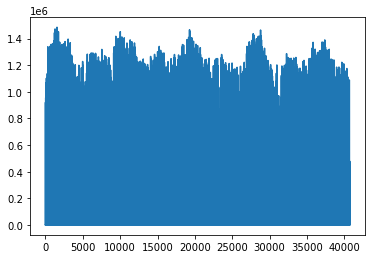

In [6]:
plt.plot(new_dataset1)

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import random
import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Activation, LSTM
from keras.engine import input_layer
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

def local_model_generate(model): #초기 모델 생성
    model.add(LSTM(1, input_shape=(1, look_back)))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model


In [14]:
num_locals = 4

local1 = np.array(new_dataset1).reshape(-1, 1)
local2 = np.array(new_dataset2).reshape(-1, 1)
local3 = np.array(new_dataset3).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0,1))

for i in range(1,num_locals):
    globals()['local{}'.format(i)] = scaler.fit_transform(globals()['local{}'.format(i)])
    print(len(globals()['local{}'.format(i)]))
    
train_size = int(len(local1)*0.85)
test_size = len(local1) - train_size

for i in range(1,num_locals):
    globals()['train_{}'.format(i)], globals()['test_{}'.format(i)] = globals()['local{}'.format(i)][0:train_size, :], globals()['local{}'.format(i)][train_size:len(local1),:]
    print(len(globals()['train_{}'.format(i)]), len(globals()['test_{}'.format(i)]))

40728
40728
40728
34618 6110
34618 6110
34618 6110


In [15]:
look_back = 1
local_epoch = 30
local_batch = 10

for i in range(1, num_locals):
    trainX, trainY = create_dataset(globals()['train_{}'.format(i)], look_back)
    testX, testY = create_dataset(globals()['test_{}'.format(i)], look_back)
    print(len(trainX), len(trainY), len(testX),  len(testY))
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    globals()['model{}'.format(i)] = Sequential()
    local_model_generate(globals()['model{}'.format(i)])
    globals()['history{}'.format(i)] = globals()['model{}'.format(i)].fit(trainX, trainY, validation_data=(testX, testY),
                                       epochs=local_epoch, batch_size=local_batch, verbose=1)

34616 34616 6108 6108
Epoch 1/30
3462/3462 [==============================] - 6s 1ms/step - loss: 0.0153 - val_loss: 0.0095
Epoch 2/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0108 - val_loss: 0.0096
Epoch 3/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 4/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 5/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 6/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 7/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 8/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 9/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 10/30
3462/3462 [==============================] - 4s 

3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 21/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 22/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 23/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 24/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 25/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 26/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 27/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 28/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 29/30
3462/3462 [==============================] - 4s 1ms/step - loss: 0.0095 -

# 여기 중요!! => 각자 데이터로 학습시킨 것

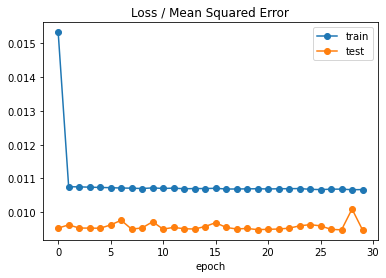

In [16]:
plt.title('Loss / Mean Squared Error')
plt.plot(history1.history['loss'], label='train', marker='o')
plt.plot(history1.history['val_loss'], label='test', marker='o')
plt.xlabel('epoch')
#plt.ylim(0.0092,0.013)
plt.legend()
plt.show()

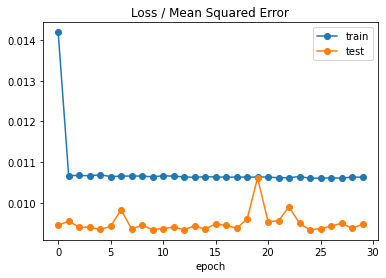

In [17]:
plt.title('Loss / Mean Squared Error')
plt.plot(history2.history['loss'], label='train', marker='o')
plt.plot(history2.history['val_loss'], label='test', marker='o')
plt.xlabel('epoch')
#plt.ylim(0.0092,0.013)
plt.legend()
plt.show()

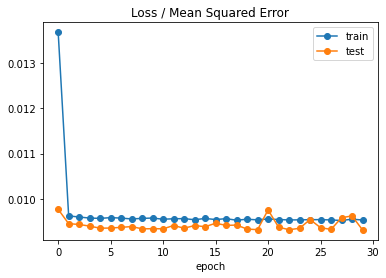

In [18]:
plt.title('Loss / Mean Squared Error')
plt.plot(history3.history['loss'], label='train', marker='o')
plt.plot(history3.history['val_loss'], label='test', marker='o')
plt.xlabel('epoch')
#plt.ylim(0.0092,0.013)
plt.legend()
plt.show()

In [10]:
for i in range(1, num_locals):
    trainPredict = globals()['model{}'.format(i)].predict(trainX)
    testPredict = globals()['model{}'.format(i)].predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    globals()['trainScore_{}'.format(i)] = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))#RMSE
    globals()['testScore_{}'.format(i)] = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

255/255 [==============================] - 0s 669us/step


Train: 212309966848.000, Test: 193668022272.000


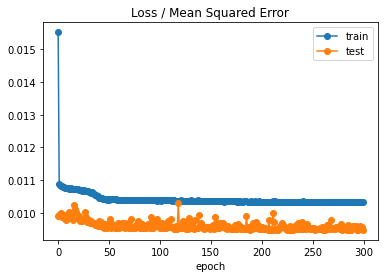

In [11]:
train_mse = model1.evaluate(trainX, trainY[0], verbose=0)
test_mse = model1.evaluate(testX, testY[0], verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train', marker='o')
plt.plot(history.history['val_loss'], label='test', marker='o')
plt.xlabel('epoch')
#plt.ylim(0.0092,0.013)
plt.legend()
plt.show()

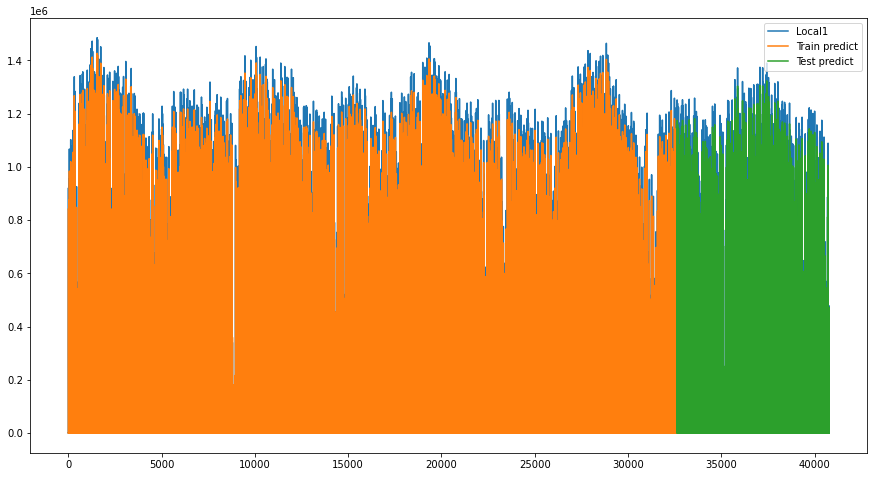

In [12]:
#plot-------------------------------------------------
trainPredict_plot = np.empty_like(local1)
trainPredict_plot[:,:] = np.nan
trainPredict_plot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredict_plot = np.empty_like(local1)
testPredict_plot[:,:] = np.nan
testPredict_plot[len(trainPredict)+(look_back*2)+1:len(local1)-1, :] = testPredict

plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(local1), label='Local1')
plt.plot(trainPredict_plot, label='Train predict')
plt.plot(testPredict_plot, label='Test predict')
plt.legend()
plt.show()

In [13]:
trainScore_1, testScore_1, trainScore_1/len(trainY[0]), testScore_1/len(testY[0])

(150422.85743097073, 144627.74902254692, 4.611651769911421, 17.737030785203203)

In [14]:
(153501.65531338903, 148159.70787192753, 5.619272076486768, 11.011498169596992)


(153501.65531338903, 148159.70787192753, 5.619272076486768, 11.011498169596992)